## Baseline Model - Classification

In [111]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, confusion_matrix, f1_score, fbeta_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

import warnings
warnings.filterwarnings('ignore')

plt.style.use('classic')

In [112]:
# load the previously created data set for the ST4000DM000, where columns with all null values 
# or columns with a std of 0 have been removed and the countdown column has already been created
classification_data = pd.read_csv('../data/special_purpose/ST4000DM000_processed_relevant.csv')

In [113]:
# create a new column based on the countdown which will be adjusted to serve a 
# classification purpose of "will fail within 30 days" or "will not fail within 30 days"
classification_data['fail_30'] = classification_data['countdown']

# function to adjust the previously created "fail_30" column and transform the data into a binary classification problem (e.g "will fail within 30 days" or "will not fail within 30 days"")
def classification_target(cols):
    """function to adjust the previously created "fail_30" column and transform data based on the previous data into 0 or 1
    if value is <= 30, the value is transformed into 1
    if value is > 30, the value is transformed into 0

    Args:
        cols: takes as an argument the panads column specified before the apply method

    Returns:
        int: 0 or 1 based on the previous information
    """
    classification = cols[0]

    if classification <= 30:
        return 1
    if classification > 30:
        return 0

# apply the created function using the .appy method
classification_data['fail_30'] = classification_data[['countdown']].apply(classification_target, axis=1)

In [114]:
# create a helper list containing only the smart features which have been deemed relevant within the EDA (5, 183, 184, 187)
columns = []

for col in classification_data.columns:
    if '5' in col or '183' in col or '184' in col or '187' in col:
        columns.append(col)

In [115]:
# look at the descriptive statistics for failing observations
classification_data[classification_data['fail_30'] == 1][columns].describe().T

,count,mean,std,min,25%,50%,75%,max
smart_5_normalized,18367.0,99.467305,3.380834,51.0,100.0,100.0,100.0,100.0
smart_5_raw,18367.0,694.266456,4462.153572,0.0,0.0,0.0,0.0,65488.0
smart_183_normalized,18367.0,93.886155,17.270035,1.0,96.0,99.0,100.0,100.0
smart_183_raw,18367.0,9.812816,48.369286,0.0,0.0,1.0,4.0,720.0
smart_184_normalized,18367.0,98.537921,9.386446,1.0,100.0,100.0,100.0,100.0
smart_184_raw,18367.0,2.039419,16.914483,0.0,0.0,0.0,0.0,340.0
smart_187_normalized,18367.0,78.445963,32.228833,1.0,70.0,97.0,100.0,100.0
smart_187_raw,18367.0,32.209833,75.116322,0.0,0.0,3.0,30.0,940.0


In [116]:
# look at the descriptive statistics for not failing observations
classification_data[classification_data['fail_30'] == 0][columns].describe().T

,count,mean,std,min,25%,50%,75%,max
smart_5_normalized,223503.0,99.853756,1.850784,51.0,100.0,100.0,100.0,100.0
smart_5_raw,223503.0,189.513376,2426.209141,0.0,0.0,0.0,0.0,65064.0
smart_183_normalized,223503.0,96.423712,12.637537,1.0,98.0,100.0,100.0,100.0
smart_183_raw,223503.0,4.688917,26.761023,0.0,0.0,0.0,2.0,720.0
smart_184_normalized,223503.0,99.870176,2.676524,1.0,100.0,100.0,100.0,100.0
smart_184_raw,223503.0,0.140034,3.110818,0.0,0.0,0.0,0.0,180.0
smart_187_normalized,223503.0,94.042626,15.829475,1.0,97.0,100.0,100.0,100.0
smart_187_raw,223503.0,7.358474,28.923403,0.0,0.0,0.0,3.0,773.0


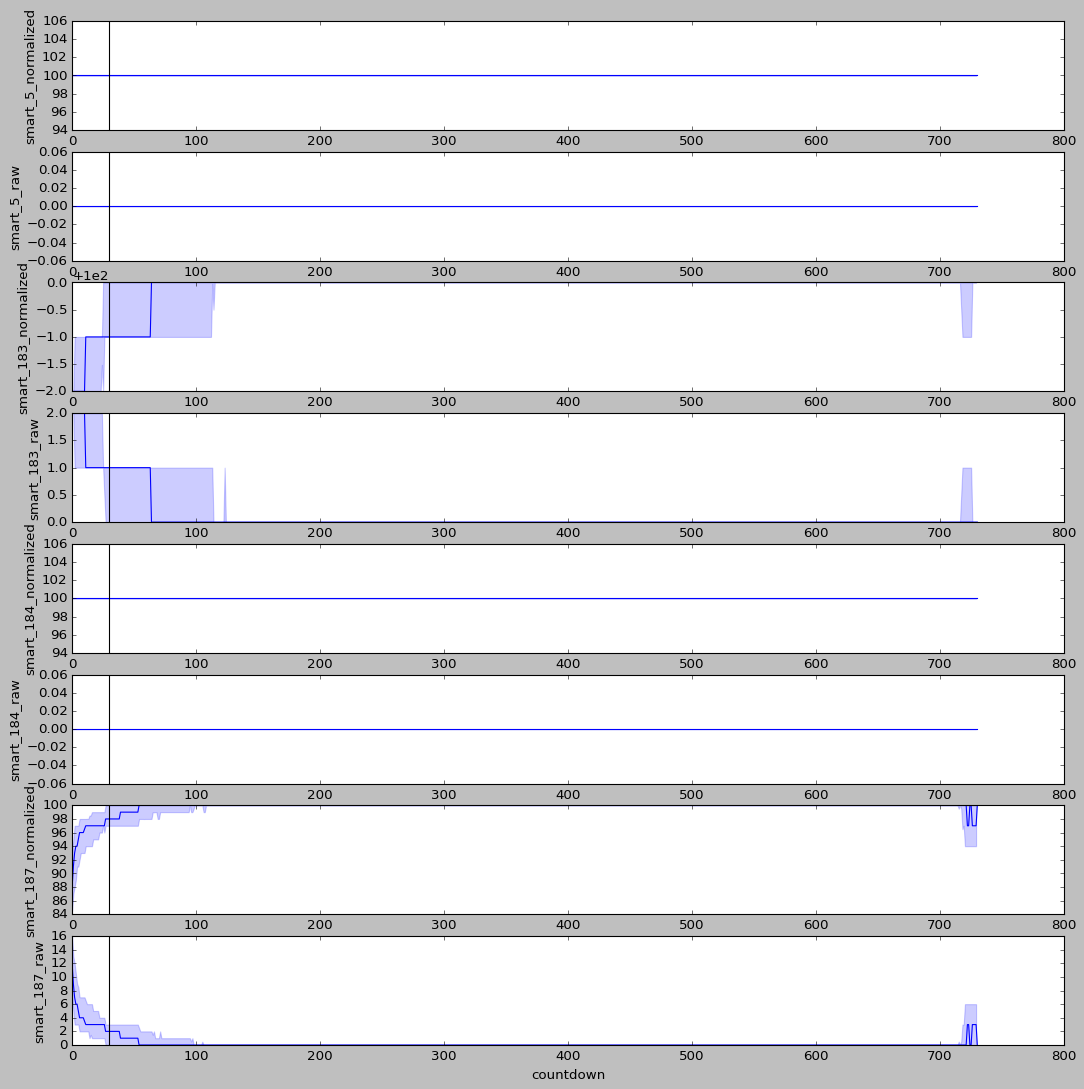

In [117]:
time_window = 30 # Line for plotting
plt.figure(figsize=(16,16))
for num, feat in enumerate(columns):
    plt.subplot(8,1,num+1)
    sns.lineplot(x=classification_data.countdown, y=classification_data[feat], estimator=np.median)
    plt.axvline(x=time_window, c='k')

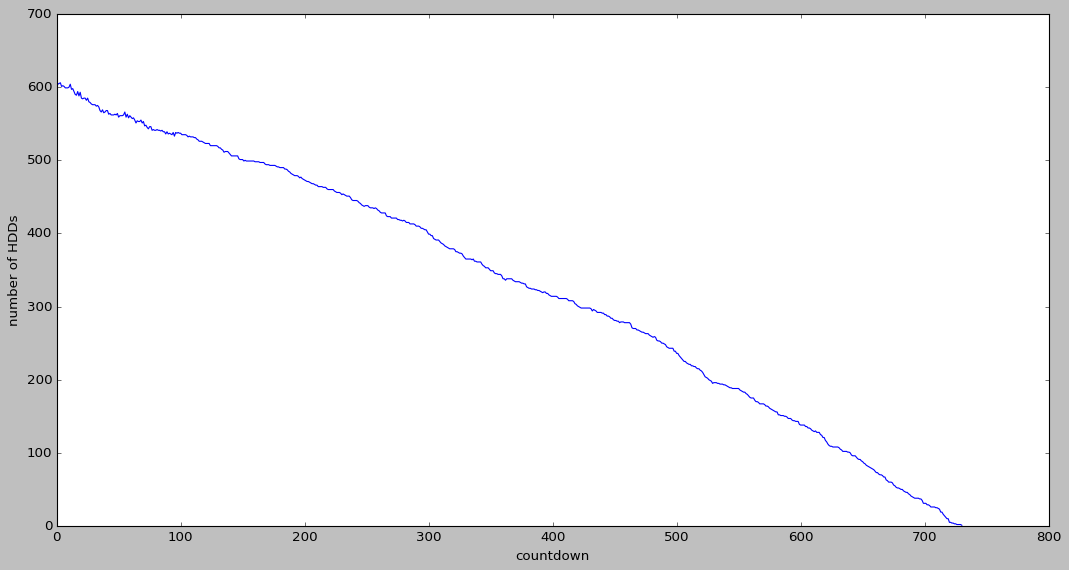

In [118]:
plt.figure(figsize=(16,8))
sns.lineplot(data=classification_data.groupby("countdown").count().date)
plt.ylabel("number of HDDs");

### Baseline Model Function

To approach the classification task, we use a baseline model which splits the data based on certain features and thresholds and divides them into fail/not fail.

In [121]:
# create a list of all column names only containing the smart ßßfeatures
updated_columns = []

for col in columns:
    if 'raw' in col:
        updated_columns.append(col)

In [134]:
# split the data into features and target
X = classification_data[updated_columns]
y = classification_data.fail_30

# split the data into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10, stratify=y)

print(f'X_train: {X_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test: {y_test.shape}')

X_train: (181402, 4)
X_test: (60468, 4)
y_train: (181402,)
y_test: (60468,)


In [135]:
train_data = pd.concat([X_train, y_train], axis=1)
train_data.shape

(181402, 5)

In [129]:
threshold = train_data[train_data['fail_30'] == 1][updated_columns].median()
threshold

smart_5_raw      0.0
smart_183_raw    1.0
smart_184_raw    0.0
smart_187_raw    3.0
dtype: float64

In [130]:
num_above_threshold = 3
y_test_pred = (X_test > threshold).sum(axis=1) > (num_above_threshold-1)
y_train_pred = (X_train > threshold).sum(axis=1) > (num_above_threshold-1)

In [ ]:
# def baseline_model(df):
#     """creates a output of 0 or 1 based on certain features and their respective threshold specified within the function

#     Args:
#         df (pandas dataframe): takes in the data frame

#     Returns:
#         list: list containing 0 or 1
#     """
    
#     y_pred = []

#     for a, b in zip(df['smart_5_raw'],df['smart_187_normalized']):
#         if a <= 4:
#             if b <= 85:
#                 y_pred.append(1)
#             else:
#                 y_pred.append(0)
#         else:
#             if b <= 70:
#                 y_pred.append(1)
#             else:
#                 y_pred.append(0)
            
#     return y_pred

Scores:
-------------------------
ROC-AUC : 0.5751
Accuracy : 0.9090
Recall   : 0.1814
Precision: 0.3235
F1 Score: 0.2325
F1 Beta : 0.1989


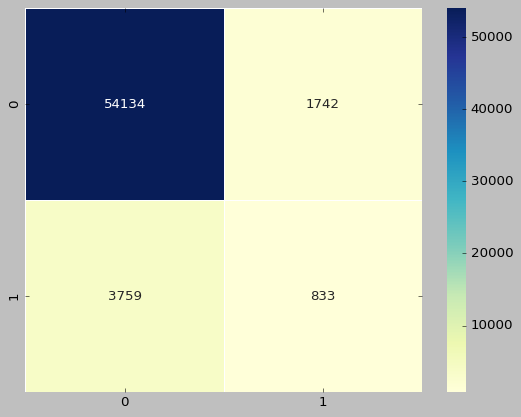

In [131]:
# print metric scores
print('Scores:')
print('-------------------------')
print("ROC-AUC : {:.4f}".format(roc_auc_score(y_test, y_test_pred)))
print("Accuracy : {:.4f}".format(accuracy_score(y_test, y_test_pred)))
print("Recall   : {:.4f}".format(recall_score(y_test, y_test_pred)))
print("Precision: {:.4f}".format(precision_score(y_test, y_test_pred)))
print("F1 Score: {:.4f}".format(f1_score(y_test, y_test_pred)))
print("F1 Beta : {:.4f}".format(fbeta_score(y_test, y_test_pred, beta=2)))

# create the confusion matrix
confusion_matrix(y_test, y_test_pred)

# plot the confusion matrix using seaborn
cm = confusion_matrix(y_test, y_test_pred)
sns.heatmap(cm, cmap='YlGnBu', annot=True, fmt='d', linewidths=.5);